## Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
from fredapi import Fred
from dotenv import load_dotenv
import os
import json
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt

load_dotenv()

FRED_API_KEY = os.getenv("FRED_API_KEY")

fred = Fred(api_key=FRED_API_KEY)

In [4]:
def plot_data_over_time(df: pd.DataFrame, y_cols, title: str = None):
    """
    Plots one or more columns over time using Year as the x-axis.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe containing the data. Must include 'Year' and the columns in y_cols.
    y_cols : str or list of str
        Column name(s) to plot against 'Year'.
    title : str, optional
        The title of the chart. Defaults to 'Selected Columns over Time'.
    """

    if 'Year' not in df.columns:
        raise ValueError("DataFrame must contain a 'Year' column.")

    if isinstance(y_cols, str):
        y_cols = [y_cols]

    for col in y_cols:
        if col not in df.columns:
            raise ValueError(f"'{col}' not found in DataFrame columns.")

    plt.figure(figsize=(10, 6))
    for col in y_cols:
        plt.plot(df['Year'], df[col], marker='o', linestyle='-', label=col)

    plt.xlabel("Year")
    plt.ylabel("Monthly Premium (USD)")
    plt.title(title if title else "Selected Columns over Time")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

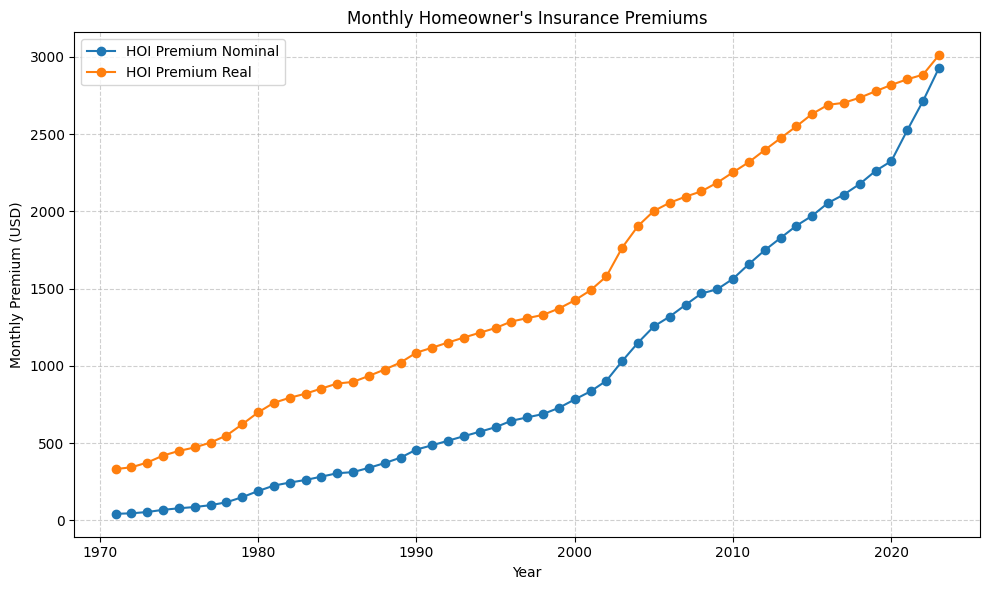

In [5]:
from categories.income_and_spending import _fetch_build_home_affordability

df = _fetch_build_home_affordability()
plot_data_over_time(df=df, y_cols=['HOI Premium Nominal', 'HOI Premium Real'], title="Monthly Homeowner's Insurance Premiums")

In [ ]:


df = _fetch_build_home_affordability()
df.tail()

In [ ]:
from categories.inflation_and_prices import _fetch_scaled_with_cpi, _fetch_cpi

df = _fetch_cpi()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
# Resample annually (year-end) and take the mean
df = df.resample('YE').mean()
df['Year'] = df.index.year
df.tail()

In [ ]:
val = _fetch_scaled_with_cpi(from_year=2022, to_year=2025, amount=100)
print(val)

## Helpers

In [ ]:
def series_to_json(series, df):
    """
    Convert a FRED series to a JSON string.
    """
    path = f"datasets/fred_{series}.json"
    # If file exists, load and merge
    if os.path.exists(path):
        # Load existing data
        with open(path, "r") as f:
            existing_data = json.load(f)
        df_existing = pd.DataFrame(existing_data)
        df_existing["Date"] = pd.to_datetime(df_existing["Date"])

        # Append only new rows
        df_combined = pd.concat([df_existing, df])
        df_combined = df_combined.drop_duplicates(subset=["Date"]).sort_values("Date")
    else:
        # No file exists, use fresh data
        df_combined = df

    # Save to JSON
    df_combined.to_json(path, orient="records", date_format="iso")

    print(f"Updated data saved to {path}")


def merge_on_year(dfs, how='inner'):
    """
    Merge a list of dataframes on the 'Year' column.

    Parameters:
    dfs (list): List of pandas DataFrames, each with a 'Year' column.
    how (str): Type of merge - 'inner', 'outer', 'left', 'right'. Default 'inner'.

    Returns:
    DataFrame: Merged dataframe.
    """
    # Safety check: make sure they all have 'Year' column
    for i, df in enumerate(dfs):
        if 'Year' not in df.columns:
            raise ValueError(f"DataFrame at index {i} is missing 'Year' column.")

    merged_df = reduce(lambda left, right: pd.merge(left, right, on='Year', how=how), dfs)
    return merged_df


def calc_mtg_pi_payment(principal, annual_rate, years=30):
    """
    Calculate monthly principal & interest payment for a mortgage.

    principal: Loan amount
    annual_rate: Annual interest rate as a percentage (e.g., 6.5 for 6.5%)
    years: Term in years (default 30)
    """
    monthly_rate = (annual_rate / 100) / 12
    n_payments = years * 12
    
    if monthly_rate == 0:
        return principal / n_payments  # handle zero interest edge case
    
    payment = principal * (monthly_rate * (1 + monthly_rate) ** n_payments) / \
              ((1 + monthly_rate) ** n_payments - 1)
    return payment


def scale_for_inflation(cpi_df: pd.DataFrame, from_year: int, to_year: int, amount: float):
    from_year_cpi = cpi_df.loc[cpi_df['Year'] == from_year, 'CPI'].values[0]
    to_year_cpi = cpi_df.loc[cpi_df['Year'] == to_year, 'CPI'].values[0]
    adjusted_value = (amount * (to_year_cpi / from_year_cpi))
    
    return round(adjusted_value, 2)


## Affordability

### Producer Price Index by Industry: Premiums for Property and Casualty Insurance: Premiums for Homeowner's Insurance (PCU9241269241262)

In [ ]:
cpi = fred.get_series('CPIAUCSL')
cpi_df = cpi.to_frame().reset_index()
cpi_df.columns = ['Date', 'CPI']
cpi_df['Date'] = pd.to_datetime(cpi_df['Date'])
cpi_df.set_index('Date', inplace=True)
cpi_df = cpi_df.resample('YE').max().round(2)
cpi_df.index = cpi_df.index.year
cpi_df.reset_index(inplace=True)
cpi_df.columns = ['Year', 'CPI']

cpi_df.tail()

In [ ]:
def get_home_affordability():
    hoi_ref_premium = 3303
    hoi_ref_year = 2024

    #CPI table - resampled to annual on mean
    cpi = fred.get_series('CPIAUCSL')
    cpi_df = cpi.to_frame().reset_index()
    cpi_df.columns = ['Date', 'CPI']
    cpi_df['Date'] = pd.to_datetime(cpi_df['Date'])
    cpi_df.set_index('Date', inplace=True)
    cpi_df = cpi_df.resample('YE').max()
    cpi_df.index = cpi_df.index.year
    cpi_df.reset_index(inplace=True)
    cpi_df.columns = ['Year', 'CPI']

    #HOI PPI table - resampled to annual on mean
    hoi_series = fred.get_series('PCU9241269241262')
    hoi_df = hoi_series.to_frame().reset_index()
    hoi_df.columns = ['Date', 'HOI PPI']
    hoi_df['Date'] = pd.to_datetime(hoi_df['Date'])
    hoi_df.set_index('Date', inplace=True)
    hoi_df = hoi_df.resample('YE').mean()
    hoi_df.index = hoi_df.index.year
    hoi_df.reset_index(inplace=True)
    hoi_df.columns = ['Year', 'HOI PPI']

    #Estimate HOI premiums based on reference year adjusted by PPI
    hoi_ref_cpi = hoi_df.loc[hoi_df['Year'] == hoi_ref_year, 'HOI PPI'].values[0]
    hoi_df['Est HOI Premium'] = (hoi_df['HOI PPI'] * (hoi_ref_premium / hoi_ref_cpi))

    #Merge the datasets
    merged_hoi_df = merge_on_year([hoi_df, cpi_df], how='outer')

    # anchor year where both PPI + Premium exist
    anchor_year = 1998
    premium_anchor = merged_hoi_df.loc[merged_hoi_df["Year"] == anchor_year, "Est HOI Premium"].values[0]
    cpi_anchor = merged_hoi_df.loc[merged_hoi_df["Year"] == anchor_year, "CPI"].values[0]

    # fill missing premiums before PPI begins
    mask = merged_hoi_df["Year"] < anchor_year
    merged_hoi_df.loc[mask, "Est HOI Premium"] = (
        premium_anchor * (merged_hoi_df.loc[mask, "CPI"] / cpi_anchor)
    )
    merged_hoi_df.loc[mask, "HOI PPI"] = np.nan
    # Add scaled premiums
    merged_hoi_df['Scaled Premium'] = merged_hoi_df.apply(lambda row: scale_for_inflation(cpi_df, 2024, row['Year'], row['Est HOI Premium']), axis=1)

    #Median Home Prices DF - resampled to annual as mean
    median_home_prices = fred.get_series('MSPUS')
    df_home_median_prices = median_home_prices.to_frame().reset_index()
    df_home_median_prices.columns = ['Date', 'Median Sales Price']
    df_home_median_prices['Date'] = pd.to_datetime(df_home_median_prices['Date'])
    df_home_median_prices.set_index('Date', inplace=True)
    df_home_median_prices_annual = df_home_median_prices.resample('YE').mean()
    df_home_median_prices_annual.index = df_home_median_prices_annual.index.year
    df_home_median_prices_annual.reset_index(inplace=True)
    df_home_median_prices_annual.columns = ['Year', 'Median Sales Price']

    #Median Family Income - annual series
    median_family_income = fred.get_series('MEFAINUSA646N')
    df_median_family_income =  median_family_income.to_frame().reset_index()
    df_median_family_income.columns = ['Date', 'Median Family Income']
    df_median_family_income['Date'] = pd.to_datetime(df_median_family_income['Date'])
    df_median_family_income.set_index('Date', inplace=True)
    df_median_family_income.index = df_median_family_income.index.year
    df_median_family_income.reset_index(inplace=True)
    df_median_family_income.columns = ['Year', 'Median Family Income']

    #30Yr Mortgage Rates - resampled to annual as mean
    mtg30 = fred.get_series('MORTGAGE30US')
    df_mtg30 = mtg30.to_frame().reset_index()
    df_mtg30.columns = ['Date', '30yr Mtg Rate']
    df_mtg30['Date'] = pd.to_datetime(df_mtg30['Date'])
    df_mtg30.set_index('Date', inplace=True)
    df_mtg30 = df_mtg30.resample('YE').mean()
    df_mtg30.index = df_mtg30.index.year
    df_mtg30.reset_index(inplace=True)
    df_mtg30.columns = ['Year', '30yr Mtg Rate']
    df_mtg30['30yr Mtg Rate'] = round(df_mtg30['30yr Mtg Rate'], 3)

    #Merge datasets and add customer features
    cdf = merge_on_year([merged_hoi_df, df_home_median_prices_annual, df_median_family_income, df_mtg30])
    cdf['Avg Loan Amount'] = cdf['Median Sales Price'] * .8
    cdf['Mtg PI Monthly'] = cdf.apply(lambda row: calc_mtg_pi_payment(row['Avg Loan Amount'], row['30yr Mtg Rate']), axis=1).round(2)
    cdf['Mtg PI Annual'] = cdf['Mtg PI Monthly'] * 12
    cdf['Mtg PII Annual'] = cdf['Mtg PI Annual'] + cdf['Scaled Premium']
    cdf['Mtg PII Monthly'] = round((cdf['Mtg PI Annual'] / 12) + (cdf['Scaled Premium'] / 12), 2)
    cdf['Mtg Ratio'] = cdf['Mtg PII Annual'] / cdf['Median Family Income']

    return cdf

cdf = get_home_affordability()
cdf.tail()

In [ ]:
value = scale_for_inflation(cpi_df, 1976, 2025, 86.88)
value

### Median Home Prices

In [ ]:
# Median Home Price
# Fred series MSPUS
median_home_prices = fred.get_series('MSPUS')
df_home_median_prices = median_home_prices.to_frame().reset_index()
df_home_median_prices.columns = ['Date', 'Median Sales Price']
df_home_median_prices['Date'] = pd.to_datetime(df_home_median_prices['Date'])
df_home_median_prices.set_index('Date', inplace=True)

df_home_median_prices_annual = df_home_median_prices.resample('YE').mean()
df_home_median_prices_annual.index = df_home_median_prices_annual.index.year
df_home_median_prices_annual.reset_index(inplace=True)
df_home_median_prices_annual.columns = ['Year', 'Median Sales Price']
df_home_median_prices_annual.tail()


### Median Family Income

In [ ]:
# Median Family Income in the United States (MEFAINUSA646N)
median_family_income = fred.get_series('MEFAINUSA646N')
df_median_family_income =  median_family_income.to_frame().reset_index()
df_median_family_income.columns = ['Date', 'Median Family Income']
df_median_family_income['Date'] = pd.to_datetime(df_median_family_income['Date'])
df_median_family_income.set_index('Date', inplace=True)
df_median_family_income.index = df_median_family_income.index.year
df_median_family_income.reset_index(inplace=True)
df_median_family_income.columns = ['Year', 'Median Family Income']

### Mortgage Rate - 30 year

In [ ]:
# 30 Year Mortgage Rate

mtg30 = fred.get_series('MORTGAGE30US')
df_mtg30 = mtg30.to_frame().reset_index()
df_mtg30.columns = ['Date', '30yr Mtg Rate']
df_mtg30['Date'] = pd.to_datetime(df_mtg30['Date'])
df_mtg30.set_index('Date', inplace=True)
df_mtg30 = df_mtg30.resample('YE').mean()
df_mtg30.index = df_mtg30.index.year
df_mtg30.reset_index(inplace=True)
df_mtg30.columns = ['Year', '30yr Mtg Rate']
df_mtg30['30yr Mtg Rate'] = round(df_mtg30['30yr Mtg Rate'], 3)

df_mtg30.tail()

In [ ]:
cdf = merge_on_year([merged_hoi_df, df_home_median_prices_annual, df_median_family_income, df_mtg30])
cdf['Avg Loan Amount'] = cdf['Median Sales Price'] * .8
cdf['Mtg PI Annual'] = cdf.apply(lambda row: calc_mtg_pi_payment(row['Avg Loan Amount'] * 12, row['30yr Mtg Rate']), axis=1).round(2)
cdf['Mtg PII Annual'] = cdf['Mtg PI Annual'] + cdf['Scaled Premium']
cdf['Mtg PII Monthly'] = round((cdf['Mtg PI Annual'] / 12) + (cdf['Scaled Premium'] / 12), 2)
cdf['Mtg Ratio'] = cdf['Mtg PII Annual'] / cdf['Median Family Income']
cdf.tail(50)

### US Population

In [ ]:
pop = fred.get_series('POPTHM')
pop_df = pop.to_frame().reset_index()
pop_df.columns = ['Date', 'US Population']
pop_df['Date'] = pd.to_datetime(pop_df['Date'])
pop_df.set_index('Date', inplace=True)

pop_df = pop_df.resample('YE').max().round(0)
pop_df.index = pop_df.index.year
pop_df.reset_index(inplace=True)
pop_df.columns = ['Year', 'US Population']
pop_df['US Population'] = pop_df['US Population'] * 1000

pop_df.tail()

### Median Personal Income

In [ ]:
# Median Personal Income In the United States (MEPAINUSA646N)
median_pers_income = fred.get_series('MEPAINUSA646N')
df_median_pers_income = median_pers_income.to_frame().reset_index()
df_median_pers_income.columns = ['Date', 'Median Personal Income']
df_median_pers_income['Date'] = pd.to_datetime(df_median_pers_income['Date'])
df_median_pers_income.set_index('Date', inplace=True)
df_median_pers_income.index = df_median_pers_income.index.year
df_median_pers_income.reset_index(inplace=True)
df_median_pers_income.columns = ['Year', 'Median Personal Income']

df_median_pers_income.tail()

In [ ]:
# Mortgage Payment Burden

# Calc monthly P&I using MORTGAGE30US and 80% of median home price
# Calc monthly T&I using average homeowner's insurance and property taxes
# Annualize the monthly payment and divide by median income

### CPI (CPIAUCSL)

In [ ]:
cpi = fred.get_series('CPIAUCSL')
cpi_df = cpi.to_frame().reset_index()
cpi_df.columns = ['Date', 'CPI']
cpi_df['Date'] = pd.to_datetime(cpi_df['Date'])
cpi_df.set_index('Date', inplace=True)
cpi_df = cpi_df.resample('YE').max()
cpi_df.index = cpi_df.index.year
cpi_df.reset_index(inplace=True)
cpi_df.columns = ['Year', 'CPI']

cpi_df.tail()

### Personal Consumption Expenditures (PCE)

In [ ]:
pce = fred.get_series('PCE')
pce_df = pce.to_frame().reset_index()
pce_df.columns = ['Date', 'PCE']
pce_df['Date'] = pd.to_datetime(pce_df['Date'])
pce_df.set_index('Date', inplace=True)
pce_df = round(pce_df.resample('YE').mean(), 2)
pce_df.index = pce_df.index.year
pce_df.reset_index(inplace=True)
pce_df.columns = ['Year', 'PCE']
pce_df['PCE'] = pce_df['PCE'] * 1000000000


pce_df.tail()

### Expenditures: Household Operations: All Consumer Units (CXUHHOPERLB0101M)

In [ ]:
hh_spend = fred.get_series('CXUHHOPERLB0101M')
hh_spend_df = hh_spend.to_frame().reset_index()
hh_spend_df.columns = ['Date', 'HH Spend Annual']
hh_spend_df['Date'] = pd.to_datetime(hh_spend_df['Date'])
hh_spend_df.set_index('Date', inplace=True)
hh_spend_df.index = hh_spend_df.index.year
hh_spend_df.reset_index(inplace=True)
hh_spend_df.columns = ['Year', 'HH Spend Annual']

hh_spend_df.tail()

### Expenditures: Vehicle Insurance: All Consumer Units (CXU500110LB0101M)

In [ ]:
vehicle_ins = fred.get_series('CXU500110LB0101M')
vehicle_ins_df = vehicle_ins.to_frame().reset_index()
vehicle_ins_df.columns = ['Date', 'Vehilcle Ins Annual']
vehicle_ins_df['Date'] = pd.to_datetime(vehicle_ins_df['Date'])
vehicle_ins_df.set_index('Date', inplace=True)
vehicle_ins_df.index = vehicle_ins_df.index.year
vehicle_ins_df.reset_index(inplace=True)
vehicle_ins_df.columns = ['Year', 'Vehicle Ins Annual']

vehicle_ins_df.tail()

### Total Households (TTLH)

In [ ]:
hh = fred.get_series("TTLHH")
hh_df = hh.to_frame().reset_index()
hh_df.columns = ['Date', 'US Households']
hh_df['Date'] = pd.to_datetime(hh_df['Date'])
hh_df.set_index('Date', inplace=True)
hh_df.index = hh_df.index.year
hh_df.reset_index(inplace=True)
hh_df.columns = ['Year', 'US Households']
hh_df['US Households'] = hh_df['US Households'] * 1000

hh_df.tail()

### PCE Services: Healthcare (DHLCRC1Q027SBEA)

In [ ]:
pce_healthcare = fred.get_series("DHLCRC1Q027SBEA")
pce_healthcare_df = pce_healthcare.to_frame().reset_index()
pce_healthcare_df.columns = ['Date', 'PCE Healthcare']
pce_healthcare_df['Date'] = pd.to_datetime(pce_healthcare_df['Date'])
pce_healthcare_df.set_index('Date', inplace=True)
pce_healthcare_df = round(pce_healthcare_df.resample('YE').mean(), 2)
pce_healthcare_df.index = pce_healthcare_df.index.year
pce_healthcare_df.reset_index(inplace=True)
pce_healthcare_df.columns = ['Year', 'PCE Healthcare']
pce_healthcare_df['PCE Healthcare'] = pce_healthcare_df['PCE Healthcare'] * 1000000000

pce_healthcare_df.tail()

### CPI Used Cars and Trucks (CUSR0000SETA02)

In [ ]:
auto_cpi = fred.get_series('CUSR0000SETA02')
auto_cpi_df = auto_cpi.to_frame().reset_index()
auto_cpi_df.columns = ['Date', 'Used Auto CPI']
auto_cpi_df['Date'] = pd.to_datetime(auto_cpi_df['Date'])
auto_cpi_df.set_index('Date', inplace=True)
auto_cpi_df = auto_cpi_df.resample('YE').mean()
auto_cpi_df.index = auto_cpi_df.index.year
auto_cpi_df.reset_index(inplace=True)
auto_cpi_df.columns = ['Year', 'Used Auto CPI']


In [ ]:
used_car_ref_year = 2024
used_car_ref_price = 28472

ref_cpi = auto_cpi_df.loc[auto_cpi_df['Year'] == used_car_ref_year, 'Used Auto CPI'].values[0]
auto_cpi_df['Est Avg Used Car Price'] = round((auto_cpi_df['Used Auto CPI'] * (used_car_ref_price / ref_cpi)),2)
auto_cpi_df.tail()


### CPI New Cars and Trucks (CUUR0000SETA01)

In [ ]:
new_auto_cpi = fred.get_series('CUSR0000SETA01')
new_auto_cpi_df = new_auto_cpi.to_frame().reset_index()
new_auto_cpi_df.columns = ['Date', 'New Auto CPI']
new_auto_cpi_df['Date'] = pd.to_datetime(new_auto_cpi_df['Date'])
new_auto_cpi_df.set_index('Date', inplace=True)
new_auto_cpi_df = new_auto_cpi_df.resample('YE').mean()
new_auto_cpi_df.index = new_auto_cpi_df.index.year
new_auto_cpi_df.reset_index(inplace=True)
new_auto_cpi_df.columns = ['Year', 'New Auto CPI']

In [ ]:
new_car_ref_year = 2024
new_car_ref_price = 48397

new_car_ref_cpi = new_auto_cpi_df.loc[new_auto_cpi_df['Year'] == new_car_ref_year, 'New Auto CPI'].values[0]
new_auto_cpi_df['Est Avg New Car Price'] = round((new_auto_cpi_df['New Auto CPI'] * (new_car_ref_price / ref_cpi)),2)
new_auto_cpi_df.tail()

### Real Disposable Personal Income (DSPI)

In [ ]:
rdpi = fred.get_series('DSPI')
rdpi_df = rdpi.to_frame().reset_index()
rdpi_df.columns = ['Date', 'RDPI']
rdpi_df['Date'] = pd.to_datetime(rdpi_df['Date'])
rdpi_df.set_index('Date', inplace=True)
rdpi_df = rdpi_df.resample('YE').max()
rdpi_df.index = rdpi_df.index.year
rdpi_df.reset_index(inplace=True)
rdpi_df.columns = ['Year', 'RDPI']
rdpi_df['RDPI'] = rdpi_df['RDPI'] * 1000000000

rdpi_df.tail()

### MERGED Affordability DF - ANNUAL 

In [ ]:
dfs = [df_home_median_prices_annual, df_median_family_income, rdpi_df, cpi_df, pce_df, hh_spend_df, vehicle_ins_df, df_mtg30, pop_df, hh_df, pce_healthcare_df]
df_merged = merge_on_year(dfs)
df_merged['Household Persons'] = round((df_merged['US Population'] / df_merged['US Households']), 2)
df_merged['RDPI Per Capita'] = round((df_merged['RDPI'] / df_merged['US Population']), 2)
#df_merged['PCE Indv Monthly'] = round(((df_merged['PCE'] / df_merged['US Population']) / 12),2)
#df_merged['PCE HH Monthly'] = round(((df_merged['PCE'] / df_merged['US Households']) / 12),2)
df_merged['PCE HH Healthcare Monthly'] = round((df_merged['PCE Healthcare'] / df_merged['US Households']) / 12,2)
#df_merged['PCE Indv Healthcare Monthly'] = round((df_merged['PCE Healthcare'] / df_merged['US Population']) / 12,2)
#df_merged['Home Price Family Income Multiplier'] = df_merged['Median Sales Price'] / df_merged['Median Family Income']
df_merged['Income Home Price Ratio'] = df_merged['Median Family Income'] / df_merged['Median Sales Price']
df_merged['Loan Amount'] = df_merged['Median Sales Price'] * .8
df_merged['Mtg P&I Annual'] = df_merged.apply(lambda row: calc_mtg_pi_payment(row['Loan Amount'] * 12, row['30yr Mtg Rate']), axis=1).round(2)
df_merged['Mtg to Fam Income Ratio'] = df_merged['Mtg P&I Annual'] / df_merged['Median Family Income']
#df_merged['Mtg to Pers Income Ratio'] = df_merged['Mtg P&I Annual'] / df_merged['Median Personal Income']
df_merged = df_merged.dropna(axis=0)
df_merged.tail(50)

In [ ]:
scale_for_inflation(cpi_df=cpi_df, from_year=2024, to_year=1990, amount=18228)

In [ ]:
# Expense to Income Ratios - goods variety

#vehicles, food, healthcare, etc..

# Disposable Income Share
# 100% - (sum of essential expenses)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_birth_death_ratios():
    """
    Plot Birth-to-Death Ratios for White, Black, and Hispanic groups.
    
    Args:
        df (pd.DataFrame): Must contain columns ["Year", "RaceEthnicity", "BirthDeathRatio"]
    """
    race_map = {
        "white": "Non-Hispanic White",
        "black": "Non-Hispanic Black",
        "hispanic": "Hispanic",
    }

    df = pd.read_csv("static_datasets/us_births_deaths.csv")

    # Filter only the 3 race categories
    df_filtered = df[df["RaceEthnicity"].isin(race_map.values())]

    # Pivot for easier plotting
    df_pivot = df_filtered.pivot(index="Year", columns="RaceEthnicity", values="BirthDeathRatio")

    # Plot
    plt.figure(figsize=(12, 6))
    for race_label in race_map.values():
        plt.plot(df_pivot.index, df_pivot[race_label], label=race_label)

    plt.title("US Birth-to-Death Ratio by Race/Ethnicity (2000–2023)")
    plt.xlabel("Year")
    plt.ylabel("Birth-to-Death Ratio")
    plt.legend(title="Race/Ethnicity")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


In [ ]:
chart = plot_birth_death_ratios()